In [2]:
!pip install torch
!pip install nilearn
!pip install nibabel
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install numpy
!pip install torch torchvision

!git clone https://gitlab.inria.fr/epione_ML/mcvae.git


fatal: destination path 'mcvae' already exists and is not an empty directory.


In [3]:
%cd mcvae 
!python ./setup.py install


/content/mcvae
running install
running bdist_egg
running egg_info
writing src/mcvae.egg-info/PKG-INFO
writing dependency_links to src/mcvae.egg-info/dependency_links.txt
writing top-level names to src/mcvae.egg-info/top_level.txt
writing manifest file 'src/mcvae.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
copying build/lib/__init__.py -> build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/__init__.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/plot.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/preprocessing.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/utilities.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/pytorch_modules.py -> build/bdist.linux-x86_64/egg/mcvae
copying build/lib/mcvae/diagnostics.py -> build/bdist.linux-x86_64/egg/mcvae
byte-compiling build/b

In [0]:
#Before running this step, got to Runtime and select "Restart and run all..."

import mcvae

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_decomposition import PLSCanonical, CCA

# Random data generation

Our journey across multivariate model starts with the generation of synthetic data. We first need to generate multivarite correlated random variables X and Y. To do so, we rely on the generative model we have seen during lesson:

$$ z\sim\mathcal{N}(0,1),$$
$$ X = z w_x,$$
$$ Y = z w_y.$$


In [6]:
# #############################################################################

# N subjects
n = 500
# here we define 2 Gaussian latents variables z = (l_1, l_2)
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

latents = np.array([l1, l2]).T

# We define two random transformations from the latent space to the space of X and Y respectively
transform_x = np.random.randint(-8,8, size = 10).reshape([2,5])
transform_y = np.random.randint(-8,8, size = 10).reshape([2,5])

# We compute data X = z w_x, and Y = z w_y
X = latents.dot(transform_x) 
Y = latents.dot(transform_y) 

# We we add some random Gaussian noise
X = X + 2*np.random.normal(size = n*5).reshape((n, 5))
Y = Y + 2*np.random.normal(size = n*5).reshape((n, 5))


print('The latent space has dimension ' + str(latents.shape))
print('The transformation for X has dimension ' + str(transform_x.shape))
print('The transformation for Y has dimension ' + str(transform_y.shape))

print('X has dimension ' + str(X.shape))
print('Y has dimension ' + str(Y.shape))


The latent space has dimension (500, 2)
The transformation for X has dimension (2, 5)
The transformation for Y has dimension (2, 5)
X has dimension (500, 5)
Y has dimension (500, 5)


[]

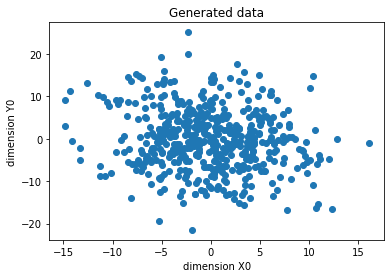

In [7]:
dimension_to_plot = 0

plt.scatter(X[:,dimension_to_plot], Y[:,dimension_to_plot])
plt.xlabel('dimension X' + str(dimension_to_plot))
plt.ylabel('dimension Y' + str(dimension_to_plot))
plt.title('Generated data')
plt.plot()

## PLS and scikit-learn: basic use


Our newly generated data can be already used to test the PLS and CCA provided by standard machie learning packages, such as scikit-learn.

In [0]:
##########################################################
# We first split the data in trainig and validation sets

# The training set is composed by a random sample of dimension N/2 
train_idx = np.random.choice(range(X.shape[0]), size = int(X.shape[0]/2), replace = False)
X_train = X[train_idx, :]

# The testing set is composed by the remaining subjects
test_idx = np.where(np.in1d(range(X.shape[0]), train_idx, assume_unique=True, invert = True))[0]
X_test = X[test_idx, :]

# We reuse the same indices to split the data Y
Y_train = Y[train_idx, :]
Y_test = Y[test_idx, :]


In [0]:
#######################################
# We fit PLS as provided by scikit-learn

#Defining PLS object
plsca = PLSCanonical(n_components=2)

#Fitting on train data
plsca.fit(X_train, Y_train)

#We project the training data in the latent dimension
X_train_r, Y_train_r = plsca.transform(X_train, Y_train)
#We project the testing data in the latent dimension
X_test_r, Y_test_r = plsca.transform(X_test, Y_test)

We note that the projections in the latent space retrieved by PLS are indeed correlated. The different dimensions of the projections are however uncorrelated. 

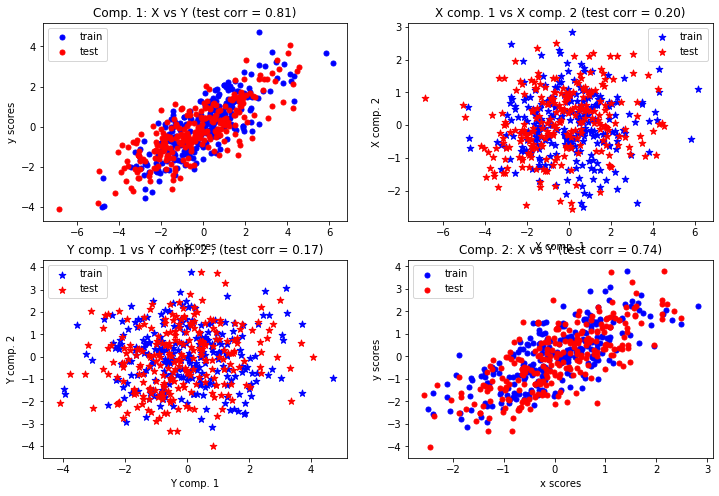

In [10]:
# Scatter plot of scores
# ~~~~~~~~~~~~~~~~~~~~~~
# 1) On diagonal plot X vs Y scores on each components
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])

plt.legend(loc="best")

plt.subplot(224)
plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
            marker="o", c="b", s=25)
plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
            marker="o", c="r", s=25)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])

plt.legend(loc="best")

# 2) Off diagonal plot components 1 vs 2 for X and Y
plt.subplot(222)
plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("X comp. 1")
plt.ylabel("X comp. 2")
plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
          % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
plt.legend(loc="best")



plt.subplot(223)
plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
            marker="*", c="b", s=50)
plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
            marker="*", c="r", s=50)
plt.xlabel("Y comp. 1")
plt.ylabel("Y comp. 2")
plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
          % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
plt.legend(loc="best")

plt.show()


In [11]:
#We can check the estimated projections
print('X projections: \n' + str(plsca.x_weights_))

print('Y projections: \n' + str(plsca.y_weights_))

X projections: 
[[-0.27179068 -0.60459242]
 [ 0.45029469 -0.21920281]
 [ 0.612812   -0.21505292]
 [ 0.14207084  0.7319863 ]
 [ 0.57240007 -0.066079  ]]
Y projections: 
[[ 0.52650507 -0.25524832]
 [ 0.5636079  -0.17119882]
 [ 0.38319219  0.79400567]
 [ 0.50625689 -0.18825525]
 [-0.04479117 -0.4895449 ]]


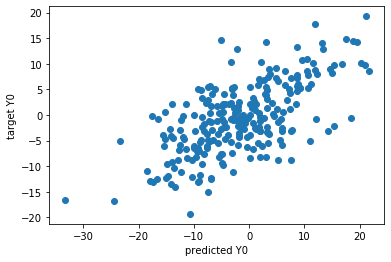

In [12]:
# We can also predict Y from X

predicted_Y_test = plsca.predict(X_test)

plt.scatter(predicted_Y_test[:,dimension_to_plot], Y_test[:,dimension_to_plot])
plt.ylabel('target Y' + str(dimension_to_plot))
plt.xlabel('predicted Y' + str(dimension_to_plot))

plt.show()


# Into the guts of latent variable models

After playing with the builti-in implementation of PLS in scikit-learn, we are going to implement our own version based on the NIPALS method we saw during lesson.

## NIPALS for PLS

In [0]:
# Nipals method for PLS

n_components = 3


# Defining empty arrays where to store results

# Reconstruction from latent space to data
loading_x = np.ndarray([X.shape[1],n_components])
loading_y = np.ndarray([Y.shape[1],n_components])

# Projections into the latent space
weight_x = np.ndarray([X.shape[1],n_components])
weight_y = np.ndarray([Y.shape[1],n_components])

# Latent variables
scores_x = np.ndarray([X.shape[0],n_components])
scores_y = np.ndarray([Y.shape[0],n_components])


# Initialization of data matrices
current_X = X
current_Y = Y

for i in range(n_components):
    # Initialization of current latent variables as a data column
    t_x = current_X[:,0]

    # NIPALS iterations
    for _ in range(100):
        # estimating Y weights given data Y and latent variables from X
        w_y = current_Y.transpose().dot(t_x)/(t_x.transpose().dot(t_x))
        # normalizing Y weights
        w_y = w_y/np.sqrt(np.sum(w_y**2))

        # estimating latent variables from Y given data Y and Y weights
        t_y = current_Y.dot(w_y)
        # estimating X weights given data X and latent variables from Y
        w_x = current_X.transpose().dot(t_y)/(t_y.transpose().dot(t_y))
        # normalizing X weights
        w_x = w_x/np.sqrt(np.sum(w_x**2))

        # estimating latent variables from X given data X and X weights
        t_x = current_X.dot(w_x)

    # Weights are such that X * weights = t
    weight_x[:,i] = w_x
    weight_y[:,i] = w_y
    
    # Latent variables
    scores_x[:,i] = t_x
    scores_x[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation = current_data - current_reconstruction
    
    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_x.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))
    

In [14]:
print('The estimated projections functions of of X are: \n' + str(weight_x))

print('\n The estimated projections functions of of Y are: \n' + str(weight_y))

The estimated projections functions of of X are: 
[[ 0.23986328  0.62882534  0.4561709 ]
 [-0.16803438  0.03197818  0.37445884]
 [-0.70308574  0.32613087  0.35334429]
 [-0.14911682 -0.70431951  0.56622851]
 [-0.63060659  0.03359717 -0.45411647]]

 The estimated projections functions of of Y are: 
[[-0.55653474  0.35807717 -0.72889096]
 [-0.52312658  0.25020037  0.53890269]
 [-0.49133737 -0.83921393  0.01205474]
 [-0.41661396  0.22022949  0.31048613]
 [ 0.04034922  0.23748573  0.28592816]]


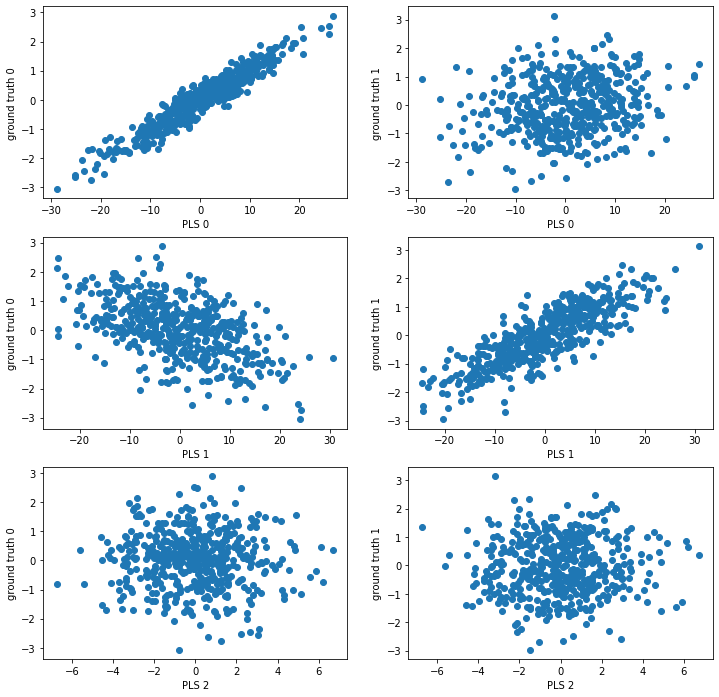

In [15]:
plt.figure(figsize=(12, 12))
plt.subplot(3,2,1)
plt.scatter(scores_x[:,0], latents[:,0])
plt.xlabel('PLS 0')
plt.ylabel('ground truth 0')
plt.subplot(3,2,2)
plt.scatter(scores_x[:,0], latents[:,1])
plt.xlabel('PLS 0')
plt.ylabel('ground truth 1')
plt.subplot(3,2,3)
plt.scatter(scores_x[:,1], latents[:,0])
plt.xlabel('PLS 1')
plt.ylabel('ground truth 0')
plt.subplot(3,2,4)
plt.scatter(scores_x[:,1], latents[:,1])
plt.xlabel('PLS 1')
plt.ylabel('ground truth 1')
plt.subplot(3,2,5)
plt.scatter(scores_x[:,2], latents[:,0])
plt.xlabel('PLS 2')
plt.ylabel('ground truth 0')
plt.subplot(3,2,6)
plt.scatter(scores_x[:,2], latents[:,1])
plt.xlabel('PLS 2')
plt.ylabel('ground truth 1')
plt.show()

Once that the PLS parameters are estimated, we can solve the regression problem for predicting Y from X. We adopt the scheme used in scikit-learn, where a rotation matrix is first estimated to accoung for non-cummutativity between projection (weights) and reconstruction (loadings).



In [0]:
# Identifying rotation from X to t
# t_x * loadings_x = X
# t_x * loadings_x.T * weight = X * weight 
# t_x =  X * weight * (loadings_x.T * weight)^-1 = X * rotations_x

rotations_x = weight_x.dot(np.linalg.pinv(loading_x.T.dot(weight_x)))

# Solving the regression from X to Y
# Y = t_x * loadings_y.T
# Y = X * rotations_x * loadings_y.T

regression_coef = np.dot(rotations_x, loading_y.T)

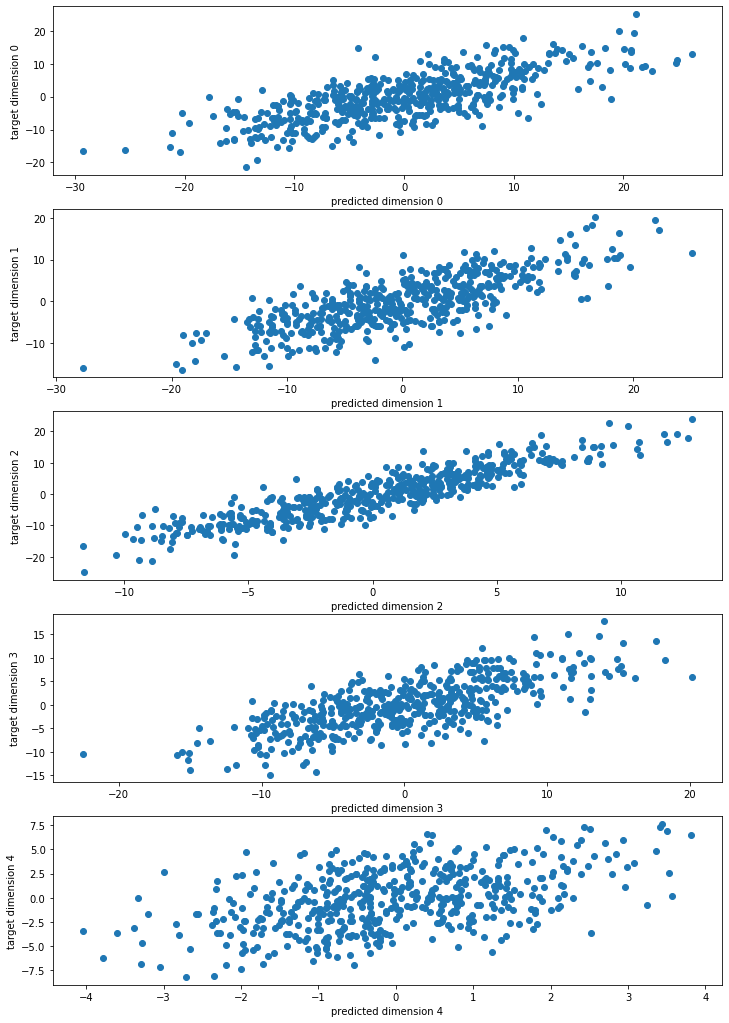

In [17]:
plt.figure(figsize=(12, 18))
for i in range(Y.shape[1]):
  plt.subplot(Y.shape[1], 1, i+1)
  plt.scatter(X.dot(regression_coef)[:,i], Y[:,i])
  plt.xlabel('predicted dimension ' + str(i))
  plt.ylabel('target dimension ' + str(i))
plt.show()

In [0]:
# Comparing with SVD of covariance matrix

eig_val_x, eig_vect, eig_val_y = np.linalg.svd(X.transpose().dot(Y))

In [19]:
print('Eigenvalues for X \n' + str(np.real(eig_val_x[:,:3])))
print('Estimated weights for X\n' + str(np.real(weight_x[:,:3])))

Eigenvalues for X 
[[-0.23986328 -0.62882534 -0.4561709 ]
 [ 0.16803438 -0.03197818 -0.37445884]
 [ 0.70308574 -0.32613087 -0.35334429]
 [ 0.14911682  0.70431951 -0.56622851]
 [ 0.63060659 -0.03359717  0.45411647]]
Estimated weights for X
[[ 0.23986328  0.62882534  0.4561709 ]
 [-0.16803438  0.03197818  0.37445884]
 [-0.70308574  0.32613087  0.35334429]
 [-0.14911682 -0.70431951  0.56622851]
 [-0.63060659  0.03359717 -0.45411647]]


In [20]:
print('Eigenvalues for Y \n' + str(np.real(eig_val_y.T[:,:3])))
print('Estimated weights for Y\n' + str(np.real(weight_y[:,:3])))

Eigenvalues for Y 
[[ 0.55653474 -0.35807717  0.72889096]
 [ 0.52312658 -0.25020037 -0.53890269]
 [ 0.49133737  0.83921393 -0.01205474]
 [ 0.41661396 -0.22022949 -0.31048613]
 [-0.04034922 -0.23748573 -0.28592816]]
Estimated weights for Y
[[-0.55653474  0.35807717 -0.72889096]
 [-0.52312658  0.25020037  0.53890269]
 [-0.49133737 -0.83921393  0.01205474]
 [-0.41661396  0.22022949  0.31048613]
 [ 0.04034922  0.23748573  0.28592816]]


In [21]:
# PLS in scikit-learn 

plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(X, Y)

PLSCanonical(algorithm='nipals', copy=True, max_iter=500, n_components=3,
             scale=False, tol=1e-06)

In [22]:
print(plsca.x_weights_)
print(plsca.y_weights_)

[[-0.24006699 -0.62699756  0.44621898]
 [ 0.16797473 -0.03091246  0.38373326]
 [ 0.70312327 -0.32607088  0.35870474]
 [ 0.1491964   0.70600622  0.55644994]
 [ 0.63048429 -0.03393339 -0.46403855]]
[[ 0.55654659 -0.35949051 -0.72960471]
 [ 0.52314229 -0.25008947  0.54501696]
 [ 0.49129791  0.83940073  0.00758048]
 [ 0.41663062 -0.21845852  0.30795088]
 [-0.0402904  -0.23644052  0.27521313]]


## NIPALS for CCA

In [0]:
# Nipals method for CCA

# Defining empty arrays where to store results

# Reconstruction from latent space to data
loading_x_cca = np.ndarray([X.shape[1],n_components])
loading_y_cca = np.ndarray([Y.shape[1],n_components])

# Projections into the latent space
scores_x_cca = np.ndarray([X.shape[0],n_components])
scores_y_cca = np.ndarray([Y.shape[0],n_components])

# Latent variables
weight_x_cca = np.ndarray([X.shape[1],n_components])
weight_y_cca = np.ndarray([Y.shape[1],n_components])

# Initialization of data matrices
current_X = X
current_Y = Y

for i in range(n_components):
    # Initialization of current latent variables as a data column
    t_x = current_X[:,0]

    # NIPALS iterations
    for _ in range(500):
        ## CCA variant
        # estimating Y weights given data Y and latent variables from X
        Y_pinv = np.linalg.pinv(current_Y)
        w_y = Y_pinv.dot(t_x)

        # normalizing Y weights
        w_y = w_y/np.sqrt(np.sum(w_y**2))
        # estimating latent variables from Y given data Y and Y weights
        t_y = current_Y.dot(w_y)

        ## CCA variant
        # estimating X weights given data X and latent variables from Y
        X_pinv = np.linalg.pinv(current_X)
        w_x = X_pinv.dot(t_y)

        # normalizing X weights
        w_x = w_x/np.sqrt(np.sum(w_x**2))
        # estimating latent variables from X given data X and X weights
        t_x = current_X.dot(w_x)

        
    # Weights are such that X * weights = t
    weight_x_cca[:,i] = w_x
    weight_y_cca[:,i] = w_y
    
    # Latent dimensions
    scores_x_cca[:,i] = t_x
    scores_x_cca[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x_cca[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y_cca[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation = current_data - current_reconstruction

    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_y.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_x.reshape(1,len(w_y)))


In [24]:
print(weight_x_cca)

[[ 0.07441155  0.07441155  0.07441155]
 [-0.19642845 -0.19642845 -0.19642845]
 [-0.77147839 -0.77147839 -0.77147839]
 [-0.08272022 -0.08272022 -0.08272022]
 [-0.59485902 -0.59485902 -0.59485902]]


In [25]:
cca = CCA(n_components=3, scale = False)
cca.fit(X,Y)
cca.x_weights_

array([[-0.07479839, -0.66964676,  0.44619949],
       [ 0.19555803,  0.02864314,  0.42006543],
       [ 0.77372978, -0.22357596,  0.25509047],
       [ 0.08021373,  0.70008462,  0.56355509],
       [ 0.59251182,  0.10318965, -0.49171696]])

## Reduced Rank Regression

We finally review reduced rank regression through the eigen-decomposition seen during lesson.

In [0]:
# Reduced Rank Regression

n_components = 2
Gamma = np.eye(n_components)

SYX = np.dot(Y.T,X)

SXX = np.dot(X.T,X)

U, S, V = np.linalg.svd(np.dot(SYX, np.dot(np.linalg.pinv(SXX), SYX.T)))

A = V[0:n_components, :].T

B = np.dot(np.dot(A.T,SYX), np.linalg.pinv(SXX))

In [27]:
A

array([[-0.64347771, -0.15274008],
       [-0.54330427, -0.20341159],
       [ 0.26387372, -0.93594947],
       [-0.44783784, -0.14732679],
       [-0.14341838,  0.19387524]])

In [28]:
B

array([[-1.04069416, -0.14560447, -1.13018143,  1.06783929, -0.39022533],
       [ 0.66716668, -0.06537384,  0.07188981, -0.69107762, -0.22211608]])

In [0]:
regression_coef_rrr = np.dot(A,B)

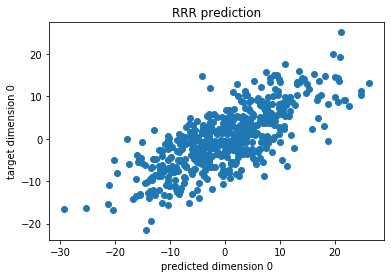

In [30]:
plt.scatter(np.dot(X,regression_coef)[:,0],Y[:,0])
plt.xlabel('predicted dimension 0')
plt.ylabel('target dimension 0')
plt.title('RRR prediction')
plt.show()

## Sparsity in latent variable models

We now focus on the effect of spurious variables in mutivariate models. To explore this new setting, we are going add spurious random features to our data matrices X and Y.  

In [0]:
## Adding 3 random dimensions
## No association is expected from these features

X_ext = np.hstack([X,np.random.randn(n*3).reshape([n,3])])
Y_ext = np.hstack([Y,np.random.randn(n*3).reshape([n,3])])

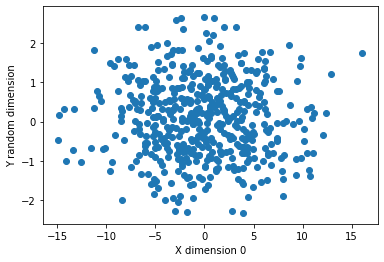

In [32]:
plt.scatter(X_ext[:,0], Y_ext[:,-1])
plt.xlabel('X dimension 0')
plt.ylabel('Y random dimension')
plt.show()

In [0]:
from sklearn import linear_model

n_components = 3

#### Sparse PLS via regularization in NIPALS [Waaijenborg, et al 2007]
# Everything is as for the standard NIPALS algorithm, with the added sparse estimation step   

loading_x_sparse = np.ndarray([X_ext.shape[1],n_components])
loading_y_sparse = np.ndarray([Y_ext.shape[1],n_components])

scores_x_sparse = np.ndarray([X_ext.shape[0],n_components])
scores_y_sparse = np.ndarray([Y_ext.shape[0],n_components])

weight_x_sparse = np.ndarray([X_ext.shape[1],n_components])
weight_y_sparse = np.ndarray([Y_ext.shape[1],n_components])

current_X = X_ext
current_Y = Y_ext

## Penalty parameter for regularization
penalty = 10

eps = 1e-4

for i in range(n_components):
    t_x = current_X[:,0]
    for _ in range(100):
        w_y = current_Y.transpose().dot(t_x)/(t_x.transpose().dot(t_x))
        w_y = w_y/np.sqrt(np.sum(w_y**2))
        t_y = current_Y.dot(w_y)
        w_x = current_X.transpose().dot(t_y)/(t_y.transpose().dot(t_y))
        w_x = w_x/np.sqrt(np.sum(w_x**2))
        t_x = current_X.dot(w_x)
        
        ## Estimating sparse model for the weights of X
        lasso_x = linear_model.Lasso(alpha = penalty)
        lasso_x.fit(t_x.reshape(-1, 1), current_X)
        
        ## Estimating sparse model for the weights of Y
        lasso_y = linear_model.Lasso(alpha = penalty)
        lasso_y.fit(t_y.reshape(-1, 1), current_Y)
        
        # Replacing the original weights with the sparse estimation
        w_x = (lasso_x.coef_ / (np.sqrt(np.sum(lasso_x.coef_**2) + eps))).reshape([X_ext.shape[1]]) 
        w_y = (lasso_y.coef_ / (np.sqrt(np.sum(lasso_y.coef_**2) + eps))).reshape([Y_ext.shape[1]])

    # Weights are such that X * weights = t
    weight_x_sparse[:,i] = w_x
    weight_y_sparse[:,i] = w_y
    
    # Latent dimensions
    scores_x_sparse[:,i] = t_x
    scores_x_sparse[:,i] = t_y
    
    # Loadings obtained by regressing X on t (X = t * loadings)
    
    loading_x_sparse[:,i] = np.dot(current_X.T, t_x)/t_x.transpose().dot(t_x) 
    loading_y_sparse[:,i] = np.dot(current_Y.T, t_y)/t_y.transpose().dot(t_y)
    
    # Deflation
    
    current_X = current_X - t_x.reshape(len(t_x),1).dot(w_x.reshape(1,len(w_x)))
    current_Y = current_Y - t_y.reshape(len(t_y),1).dot(w_y.reshape(1,len(w_y)))
    

We observe that the new weights are similar to the ones estimated before. However the parameters associated with the spurious dimension are entirely set to zero. This indicates that the model does not find these features necessary to explain the common variability between X and Y. There are also other weights which are set to zero, corresponding to the third latent dimension. This makes sense, as our synthetic data was indeed created with only two latent dimensions.

In [36]:
weight_x_sparse

array([[ 0.28378094,  0.52271685,  0.        ],
       [-0.11567312,  0.        ,  0.        ],
       [-0.68049339,  0.        ,  0.        ],
       [-0.18828943, -0.85182357,  0.        ],
       [-0.638308  ,  0.        , -0.        ],
       [ 0.        , -0.        , -0.        ],
       [-0.        , -0.        ,  0.        ],
       [-0.        , -0.        , -0.        ]])

In [38]:
weight_y_sparse

array([[-0.66482429,  0.29778698,  0.        ],
       [-0.58562738,  0.17407799,  0.        ],
       [-0.10267045, -0.91435999,  0.        ],
       [-0.45206793,  0.13762377,  0.        ],
       [-0.        ,  0.16083487,  0.        ],
       [-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [ 0.        , -0.        , -0.        ]])

In [39]:
## Non-sparse parameters previously estimated

weight_x

array([[ 0.23986328,  0.62882534,  0.4561709 ],
       [-0.16803438,  0.03197818,  0.37445884],
       [-0.70308574,  0.32613087,  0.35334429],
       [-0.14911682, -0.70431951,  0.56622851],
       [-0.63060659,  0.03359717, -0.45411647]])

In [40]:
weight_y

array([[-0.55653474,  0.35807717, -0.72889096],
       [-0.52312658,  0.25020037,  0.53890269],
       [-0.49133737, -0.83921393,  0.01205474],
       [-0.41661396,  0.22022949,  0.31048613],
       [ 0.04034922,  0.23748573,  0.28592816]])

In [42]:
## PLS result from scikit-learn PLS on the data augmented with spurious dimensions 

plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(X_ext, Y_ext)
print(plsca.x_weights_)
print(plsca.y_weights_)

[[-0.24006002 -0.62695902  0.4388406 ]
 [ 0.16797265 -0.0308953   0.19975232]
 [ 0.70311053 -0.32600082  0.34554512]
 [ 0.14918579  0.70595389  0.54601561]
 [ 0.63047793 -0.03389408 -0.40426171]
 [-0.00474413  0.01234278 -0.400783  ]
 [ 0.00076722 -0.00341826  0.14039968]
 [ 0.00317039  0.00275537  0.07884702]]
[[ 5.56545575e-01 -3.59442686e-01 -6.37668656e-01]
 [ 5.23136881e-01 -2.50061259e-01  3.29887832e-01]
 [ 4.91280011e-01  8.39395716e-01  6.05134344e-02]
 [ 4.16642638e-01 -2.18506088e-01  4.12771934e-01]
 [-4.02746958e-02 -2.36512649e-01  4.54419732e-01]
 [ 3.88841485e-03 -8.06412869e-04 -2.80895531e-01]
 [-3.18480388e-04 -9.74573888e-05 -1.43075177e-01]
 [ 6.45396194e-04  1.16197692e-03 -6.81179832e-02]]


## Cross-validating components

In addition to sparsity, the optimal number of components in latent variable models can be identified by cross-validation. 
A common strategy is to train the model on a subset of the data and to quantify the *predicted residual error sum of squares* (PRESS) in non-overlapping testing data. We can finally choose the number of latent dimensions leading to the lowest average PRESS. 

In [0]:
n_cross_valid_run = 200

# number of components to test
n_components = 5

rep_results = [] 
for i in range(n_components):
  rep_results.append([])

for k in range(n_components):
  for i in range(n_cross_valid_run):

    # Sampling disjoint set of indices for splitting the data
    batch1_idx = np.random.choice(range(X_ext.shape[0]), size = int(X_ext.shape[0]/2), replace = False)
    batch2_idx = np.where(np.in1d(range(X_ext.shape[0]), batch1_idx, assume_unique=True, invert = True))[0]

    # Creating independent data batches for X
    X_1 = X_ext[batch1_idx, :]
    X_2 = X_ext[batch2_idx, :]

    # Creating independent data batches for Y
    Y_1 = Y_ext[batch1_idx, :]
    Y_2 = Y_ext[batch2_idx, :]

    # Creating a model for each data batch
    plsca1 = PLSCanonical(n_components = k+1, scale = False)
    plsca2 = PLSCanonical(n_components = k+1, scale = False)

    # Fitting a model for each data batch
    plsca1.fit(X_1,Y_1)
    plsca2.fit(X_2,Y_2)

    # Quantifying the prediction error on the unseen data batch
    err1 = np.sum((plsca1.predict(X_2) - Y_2)**2)
    err2 = np.sum((plsca2.predict(X_1) - Y_1)**2)

    rep_results[k].append(np.mean([err1,err2]))


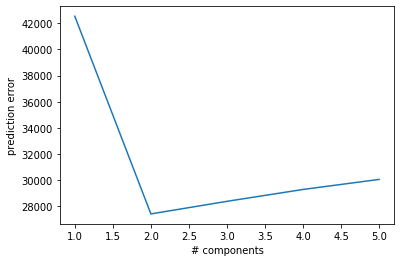

In [80]:
plt.plot(range(1,n_components+1),np.mean(rep_results, 1))
plt.xlabel('# components')
plt.ylabel('prediction error')
plt.show()

## Application on ADNI data

We are going to load volumetric and cognitive data for a sample from the ADNI dataset.
The exercise consists in applying the methods seen so far to understand the relationship between this kind of variables.

In [50]:
import pandas as pd

volumes = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/volumes.csv')
volumes


,Unnamed: 0,RID,WholeBrain.bl,Ventricles.bl,Hippocampus.bl,MidTemp.bl,Entorhinal.bl
0,2,3,0.588244,0.044046,0.002769,0.009591,0.000932
1,3,4,0.687715,0.023582,0.004090,0.011679,0.002372
2,4,5,0.680556,0.020760,0.004312,0.013173,0.002702
3,7,8,0.679540,0.013436,0.004355,0.014380,0.003001
4,8,10,0.702524,0.018230,0.003728,0.013418,0.001819
...,...,...,...,...,...,...,...
912,1369,5288,0.702970,0.033736,0.004938,0.014715,0.002431
913,1370,5289,0.684950,0.023104,0.005107,0.016010,0.002401
914,1371,5290,0.736837,0.007401,0.005387,0.013707,0.002839
915,1372,5292,0.770626,0.011632,0.005554,0.013896,0.002963


In [0]:
volumes_value = np.array(volumes.iloc[:,2:]).reshape([len(volumes.RID),5])

# Standardization of volumetric measures
for i in range(volumes_value.shape[1]):
    volumes_value[:,i] = (volumes_value[:,i] - np.mean(volumes_value[:,i]))/np.std(volumes_value[:,i])

In [52]:
cognition = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/cognition.csv')

cognition

,Unnamed: 0,RID,CDRSB.bl,ADAS11.bl,MMSE.bl,RAVLT.immediate.bl,RAVLT.learning.bl,RAVLT.forgetting.bl,FAQ.bl
0,2,3,4.5,22.00,20,22,1,4,10
1,3,4,1.0,14.33,27,37,7,4,0
2,4,5,0.0,8.67,29,37,4,4,0
3,7,8,0.0,5.00,28,51,7,3,0
4,8,10,5.0,12.33,24,20,2,5,11
...,...,...,...,...,...,...,...,...,...
912,1369,5288,0.0,6.00,30,53,6,3,0
913,1370,5289,0.0,9.00,29,50,10,7,0
914,1371,5290,0.0,5.00,29,53,8,4,1
915,1372,5292,0.0,3.00,30,41,9,7,1


In [0]:
cognition_value = np.array(cognition.iloc[:,2:]).reshape([len(cognition.RID),7])

# Standardization of cognitive measures

for i in range(cognition_value.shape[1]):
    cognition_value[:,i] = (cognition_value[:,i] - np.mean(cognition_value[:,i]))/np.std(cognition_value[:,i])

In [54]:
plsca_adni = PLSCanonical(n_components=3, scale = False)
plsca_adni.fit(cognition_value,volumes_value)
print(plsca_adni.x_weights_)
print(plsca_adni.y_weights_)

[[ 0.39899923  0.10784175  0.46702126]
 [ 0.46449063 -0.17600757  0.30801738]
 [-0.41970768  0.02252307  0.05284719]
 [-0.41480449  0.25193258  0.5752117 ]
 [-0.33759258 -0.35942915  0.527915  ]
 [ 0.09007329  0.86611085  0.09016765]
 [ 0.39338126 -0.11864597  0.25793539]]
[[-0.39539685  0.40966994  0.55358155]
 [ 0.30948675 -0.25355692  0.03687062]
 [-0.50592711 -0.48090226  0.50498596]
 [-0.48167611  0.53524535 -0.4254469 ]
 [-0.50980895 -0.50012484 -0.50613451]]


In [0]:
n_cross_valid_run = 200

# number of components to test
n_components = 5

rep_results = [] 
for i in range(n_components):
  rep_results.append([])

for k in range(n_components):
  for i in range(n_cross_valid_run):

    # Sampling disjoint set of indices for splitting the data
    batch1_idx = np.random.choice(range(cognition_value.shape[0]), size = int(cognition_value.shape[0]/2), replace = False)
    batch2_idx = np.where(np.in1d(range(cognition_value.shape[0]), batch1_idx, assume_unique=True, invert = True))[0]

    # Creating independent data batches for X
    X_1 = cognition_value[batch1_idx, :]
    X_2 = cognition_value[batch2_idx, :]

    # Creating independent data batches for Y
    Y_1 = volumes_value[batch1_idx, :]
    Y_2 = volumes_value[batch2_idx, :]

    # Creating a model for each data batch
    cca_adni1 = CCA(n_components = k+1, scale = False)
    cca_adni2 = CCA(n_components = k+1, scale = False)

    # Fitting a model for each data batch
    cca_adni1.fit(X_1,Y_1)
    cca_adni2.fit(X_2,Y_2)

    # Quantifying the prediction error on the unseen data batch
    err1 = np.sum((cca_adni1.predict(X_2) - Y_2)**2)
    err2 = np.sum((cca_adni2.predict(X_1) - Y_1)**2)

    rep_results[k].append(np.mean([err1,err2]))


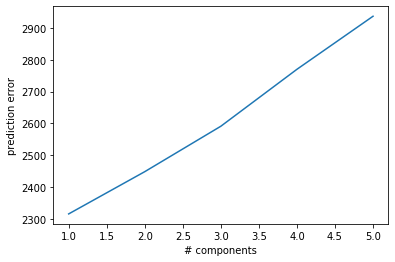

In [82]:
plt.plot(range(1,n_components+1),np.mean(rep_results, 1))
plt.xlabel('# components')
plt.ylabel('prediction error')
plt.show()

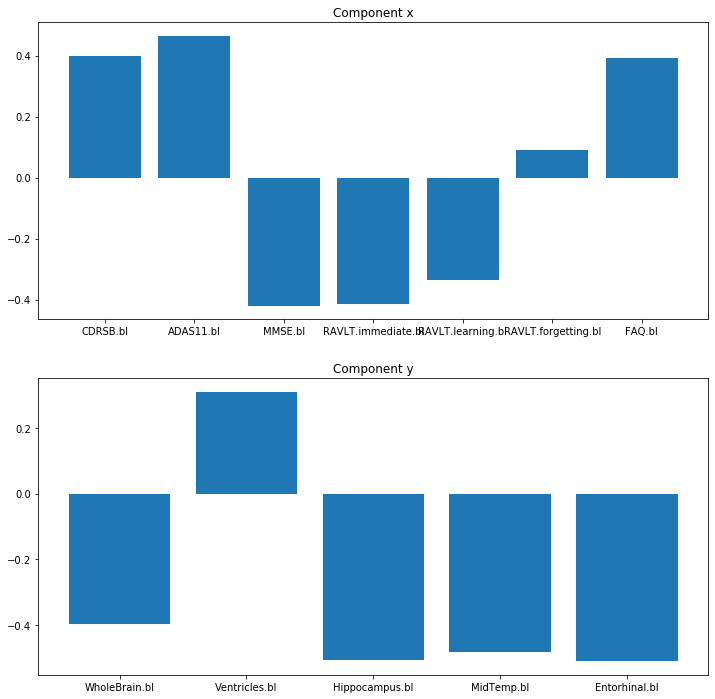

In [85]:
plsca_adni = PLSCanonical(n_components=1, scale = False)
plsca_adni.fit(cognition_value,volumes_value)


plt.figure(figsize=(12, 12))
plt.subplot(2,1,1)
plt.bar(np.arange(len(plsca_adni.x_weights_[:,0])), plsca_adni.x_weights_[:,0], tick_label = cognition.columns[2:])
plt.title('Component x')
plt.subplot(2,1,2)
plt.bar(np.arange(len(plsca_adni.y_weights_[:,0])), plsca_adni.y_weights_[:,0], tick_label = volumes.columns[2:])
plt.title('Component y')
plt.show()


# Multi-channel Variational Autoencoder

The last part of this tutorial concerns the use of the *multi-channel variational autoencoder* (https://gitlab.inria.fr/epione_ML/mcvae), a more advanced  methods for the joint analysis and prediction of several modalities.




In [87]:
from mcvae import pytorch_modules, utilities, preprocessing, plot, diagnostics
from pathlib import Path
import torch

DEVICE = pytorch_modules.DEVICE
print(f"Running on {DEVICE}")

Running on cpu


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
### Data in mcvae is specified by: 
# 1 - a dictionary with the data characteristics

init_dict = {
    'n_channels': 2, # X and Y
    'lat_dim': n_components,  
    'n_feats': tuple([X.shape[1], Y.shape[1]]),
}

# 2 - a list with the different modalities

data = []
data.append(torch.FloatTensor(X)) #warning: data matrices must be converted to type torch.FLoatTensor
data.append(torch.FloatTensor(Y)) #warning: data matrices must be converted to type torch.FLoatTensor

In [0]:
# Here we create an instance of the model

adam_lr = 1e-2
n_epochs = 4000

# Multi-Channel VAE
torch.manual_seed(24)
model = pytorch_modules.MultiChannelBase(**init_dict)

In [90]:
###################
## Model Fitting ##
###################

model.init_loss()
model.optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)
model.optimize(epochs = n_epochs, data = data)

====> Epoch:    0/4000 (0%)	Loss: 769156.0625	LL: -25650.9883	KL: 743505.0625	LL/KL: -0.0345
====> Epoch:  100/4000 (2%)	Loss: 567.6469	LL: -69.8924	KL: 497.7544	LL/KL: -0.1404
====> Epoch:  200/4000 (5%)	Loss: 422.2413	LL: -67.0368	KL: 355.2045	LL/KL: -0.1887
====> Epoch:  300/4000 (8%)	Loss: 323.0336	LL: -62.6579	KL: 260.3756	LL/KL: -0.2406
====> Epoch:  400/4000 (10%)	Loss: 258.6889	LL: -60.3975	KL: 198.2914	LL/KL: -0.3046
====> Epoch:  500/4000 (12%)	Loss: 216.6125	LL: -60.0364	KL: 156.5761	LL/KL: -0.3834
====> Epoch:  600/4000 (15%)	Loss: 185.8728	LL: -58.6217	KL: 127.2511	LL/KL: -0.4607
====> Epoch:  700/4000 (18%)	Loss: 162.9803	LL: -56.9606	KL: 106.0197	LL/KL: -0.5373
====> Epoch:  800/4000 (20%)	Loss: 147.6031	LL: -57.6431	KL: 89.9600	LL/KL: -0.6408
====> Epoch:  900/4000 (22%)	Loss: 134.9603	LL: -57.7645	KL: 77.1958	LL/KL: -0.7483
====> Epoch: 1000/4000 (25%)	Loss: 124.1780	LL: -56.9891	KL: 67.1889	LL/KL: -0.8482
====> Epoch: 1100/4000 (28%)	Loss: 116.4586	LL: -57.2979	KL: 59

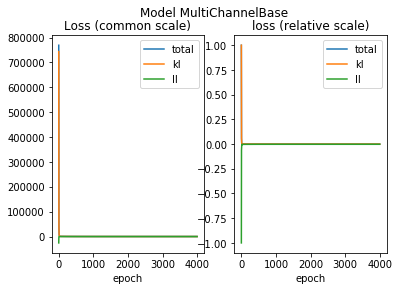

In [91]:
## Plotting model convergence

diagnostics.plot_loss(model)

The plot above indicates that the model converged smoothly.

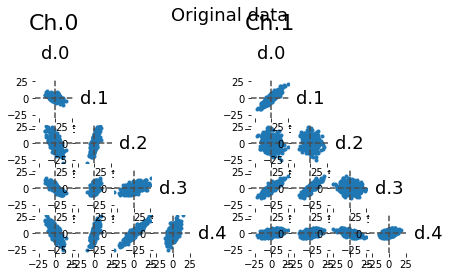

In [92]:
# We can plot the original data, dimension x dimension

plot.lsplom(data, title = 'Original data')

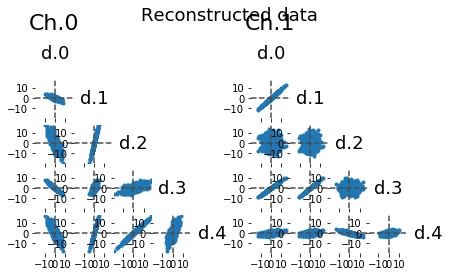

In [93]:
# We can estimate the reconstructed data (decoding from the latent space)
x_hat = model.reconstruct(data)

# Plotting the reconstructed data, dimension x dimension
plot.lsplom(utilities.ltonumpy(x_hat), title = 'Reconstructed data')

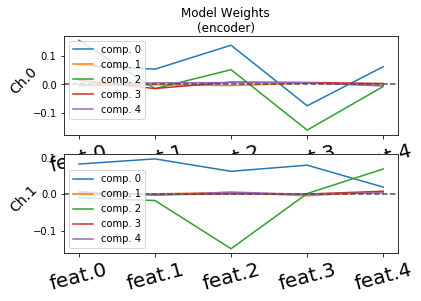

In [94]:
## Plotting the weights of the encoder

diagnostics.plot_weights(model, side = 'encoder')

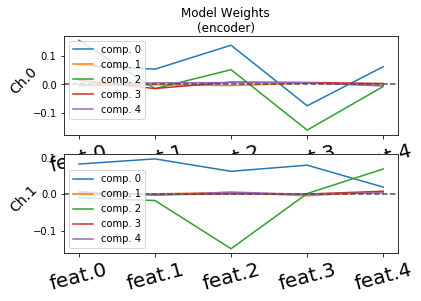

In [95]:
## Plotting the weights of the decoder

diagnostics.plot_weights(model, side = 'encoder')

In [0]:
# Inspecting model parameters

# Decoding parameters
weights_decoding_X = model.W_out[0]
weights_decoding_Y = model.W_out[1]

In [97]:
weights_decoding_X.weight

Parameter containing:
tensor([[-0.8767, -0.0609,  2.0331,  0.1913,  0.0260],
        [ 0.8342, -0.0076, -0.4150, -0.1050,  0.0461],
        [ 3.5937, -0.0126, -1.3149,  0.1438,  0.2352],
        [ 0.3878,  0.0311, -1.9384,  0.0620,  0.0321],
        [ 3.1171, -0.0213, -1.7296,  0.0155, -0.1198]], requires_grad=True)

In [98]:
weights_decoding_Y.weight

Parameter containing:
tensor([[ 3.0082e+00, -1.6935e-01,  9.7447e-01,  1.8464e-01,  1.4241e-01],
        [ 2.6560e+00, -4.6249e-02,  5.9651e-01,  2.7576e-02, -4.4439e-02],
        [ 7.4184e-02,  6.7746e-02, -3.6808e+00,  7.0951e-02,  2.7939e-01],
        [ 2.1681e+00, -1.0625e-01,  5.6062e-01,  4.0759e-02,  7.5104e-04],
        [ 3.8868e-01,  3.2627e-02,  1.0187e+00,  6.3052e-02, -1.9012e-03]],
       requires_grad=True)

In [0]:
# Encoding parameters
weights_encoding_X = model.W_mu[0]
weights_encoding_Y = model.W_mu[1]

In [100]:
weights_encoding_X.weight

Parameter containing:
tensor([[ 0.0673,  0.0534,  0.1376, -0.0753,  0.0621],
        [-0.0048, -0.0015, -0.0043,  0.0041, -0.0032],
        [ 0.1549, -0.0150,  0.0515, -0.1608, -0.0074],
        [ 0.0142, -0.0147,  0.0081,  0.0067,  0.0030],
        [-0.0014,  0.0051,  0.0063,  0.0057, -0.0058]], requires_grad=True)

In [101]:
weights_encoding_Y.weight

Parameter containing:
tensor([[ 0.0830,  0.0973,  0.0630,  0.0799,  0.0196],
        [-0.0033,  0.0013,  0.0048, -0.0044,  0.0072],
        [-0.0101, -0.0172, -0.1497,  0.0019,  0.0694],
        [ 0.0049, -0.0015,  0.0009,  0.0006,  0.0083],
        [ 0.0068, -0.0023,  0.0060, -0.0003,  0.0040]], requires_grad=True)

In [0]:
# Here we compute the encoding and plot the latent dimensions against our original ground truth for the syntetic data

encoding = model.encode(data)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()

We note that the estimated encoding is correlated with the original latent dimensions. There seems to be however some redundancy. This motivates the use of a *sparse model*.

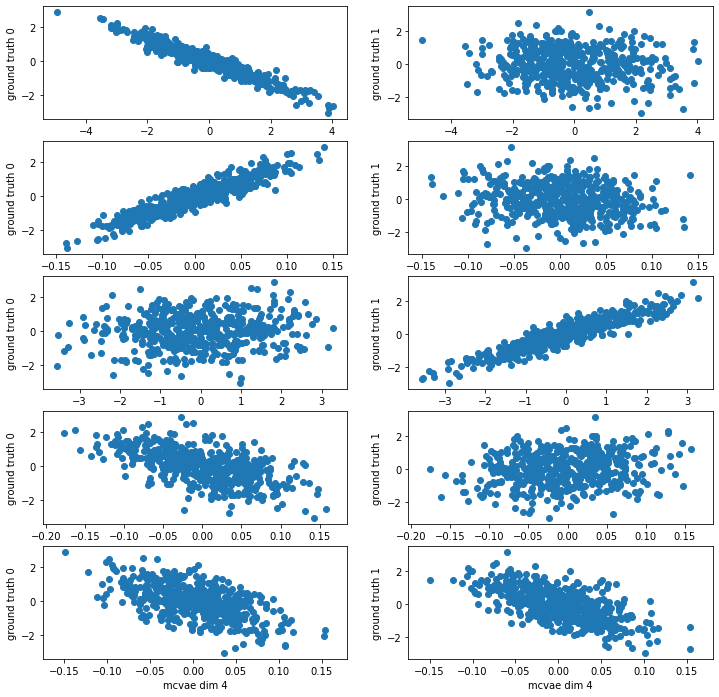

In [104]:
plt.figure(figsize=(12, 12))
for idx,k in enumerate(range(n_components)):
  plt.subplot(n_components,2,2*idx+1)
  plt.scatter(encoding_x[:,k], latents[:,0])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 0')
  plt.subplot(n_components,2,2*idx+2)
  plt.scatter(encoding_x[:,k], latents[:,1])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 1')
plt.show()

In [105]:
# Calling sparse mcvae

adam_lr = 1e-2
n_epochs = 4000

model_sparse1 = pytorch_modules.MultiChannelSparseVAE(**init_dict)

model_sparse1.init_loss()
model_sparse1.optimizer = torch.optim.Adam(model_sparse1.parameters(), lr=adam_lr)
model_sparse1.optimize(epochs = n_epochs, data = data)


====> Epoch:    0/4000 (0%)	Loss: 73.7849	LL: -69.4913	KL: 4.2937	LL/KL: -16.1846
====> Epoch:  100/4000 (2%)	Loss: 58.4433	LL: -54.5512	KL: 3.8921	LL/KL: -14.0160
====> Epoch:  200/4000 (5%)	Loss: 57.8176	LL: -52.8650	KL: 4.9527	LL/KL: -10.6741
====> Epoch:  300/4000 (8%)	Loss: 56.2893	LL: -50.5164	KL: 5.7729	LL/KL: -8.7507
====> Epoch:  400/4000 (10%)	Loss: 55.9150	LL: -49.4249	KL: 6.4901	LL/KL: -7.6155
====> Epoch:  500/4000 (12%)	Loss: 55.8457	LL: -48.8108	KL: 7.0349	LL/KL: -6.9384
====> Epoch:  600/4000 (15%)	Loss: 55.6441	LL: -47.8642	KL: 7.7799	LL/KL: -6.1523
====> Epoch:  700/4000 (18%)	Loss: 55.4608	LL: -47.2584	KL: 8.2025	LL/KL: -5.7615
====> Epoch:  800/4000 (20%)	Loss: 55.1689	LL: -46.8581	KL: 8.3107	LL/KL: -5.6383
====> Epoch:  900/4000 (22%)	Loss: 54.9858	LL: -46.6992	KL: 8.2866	LL/KL: -5.6355
====> Epoch: 1000/4000 (25%)	Loss: 55.3386	LL: -47.0469	KL: 8.2917	LL/KL: -5.6740
====> Epoch: 1100/4000 (28%)	Loss: 55.1516	LL: -46.9109	KL: 8.2407	LL/KL: -5.6926
====> Epoch: 1200

The sparse model estimates a probability of redundancy associated to each dimension. This means that we can retain only the dimensions with low probability of redundancy. In this case the model correctly identifies only 2 meaningful latent dimensions. 

In [108]:
print('Probability of redundancy: ', model_sparse1.dropout.detach().numpy())

Probability of redundancy:  [[0.03204359 0.08405019 0.99696034 0.99725085 0.9966452 ]]


In [0]:
# We fix a redundancy threshold

model_sparse1.dropout_threshold = 0.5

Dropout threshold: 0.5
Components kept: [0, 1]


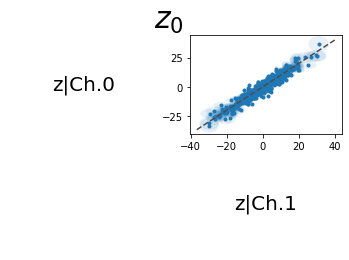

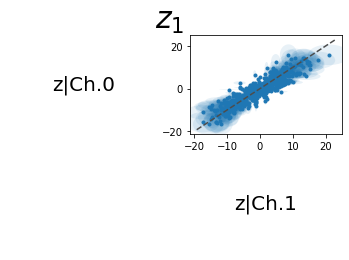

In [111]:
# We plot the remaining latent dimensions

diagnostics.plot_latent_space(model_sparse1, data)

In [112]:
# We repeate the same exercise with the synthetic data with redundant dimensions

init_dict = {
    'n_channels': 2, # X and Y
    'lat_dim': n_components + 3,
    'n_feats': tuple([X_ext.shape[1], Y_ext.shape[1]]),
}


data_sparse = []
data_sparse.append(torch.FloatTensor(X_ext))
data_sparse.append(torch.FloatTensor(Y_ext))

adam_lr = 1e-2
n_epochs = 4000

model_sparse = pytorch_modules.MultiChannelSparseVAE(**init_dict)

model_sparse.init_loss()
model_sparse.optimizer = torch.optim.Adam(model_sparse.parameters(), lr=adam_lr)
model_sparse.optimize(epochs = n_epochs, data = data_sparse)

====> Epoch:    0/4000 (0%)	Loss: 106.3371	LL: -99.4117	KL: 6.9255	LL/KL: -14.3545
====> Epoch:  100/4000 (2%)	Loss: 82.2036	LL: -77.5955	KL: 4.6081	LL/KL: -16.8390
====> Epoch:  200/4000 (5%)	Loss: 77.9596	LL: -73.2793	KL: 4.6803	LL/KL: -15.6571
====> Epoch:  300/4000 (8%)	Loss: 75.9487	LL: -71.0117	KL: 4.9370	LL/KL: -14.3837
====> Epoch:  400/4000 (10%)	Loss: 73.9578	LL: -68.1563	KL: 5.8015	LL/KL: -11.7481
====> Epoch:  500/4000 (12%)	Loss: 73.0192	LL: -66.6680	KL: 6.3513	LL/KL: -10.4968
====> Epoch:  600/4000 (15%)	Loss: 73.4742	LL: -66.8893	KL: 6.5849	LL/KL: -10.1580
====> Epoch:  700/4000 (18%)	Loss: 73.3999	LL: -66.6419	KL: 6.7580	LL/KL: -9.8612
====> Epoch:  800/4000 (20%)	Loss: 73.0665	LL: -65.9368	KL: 7.1297	LL/KL: -9.2482
====> Epoch:  900/4000 (22%)	Loss: 72.4789	LL: -64.4744	KL: 8.0044	LL/KL: -8.0548
====> Epoch: 1000/4000 (25%)	Loss: 72.2744	LL: -63.7407	KL: 8.5337	LL/KL: -7.4693
====> Epoch: 1100/4000 (28%)	Loss: 72.3286	LL: -63.8637	KL: 8.4650	LL/KL: -7.5445
====> Epoch:

We see that the model recognises again only two meaningful latent dimensions

In [113]:
print('Probability of redundancy: ', model_sparse.dropout.detach().numpy())
indices = np.where(model_sparse.dropout.detach().numpy().flatten() < 0.9)[0]
print('Non-redundant components: ', indices)

Probability of redundancy:  [[0.99512726 0.9947953  0.03237422 0.99527    0.08663137 0.99550647
  0.9951949  0.99596035]]
Non-redundant components:  [2 4]


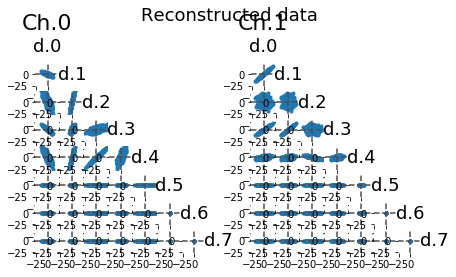

In [114]:
model_sparse.dropout_threshold = 0.2

x_hat = model_sparse.reconstruct(data_sparse)
plot.lsplom(utilities.ltonumpy(x_hat), title = 'Reconstructed data')

Dropout threshold: 0.2
Components kept: [2, 4]


<Figure size 864x576 with 0 Axes>

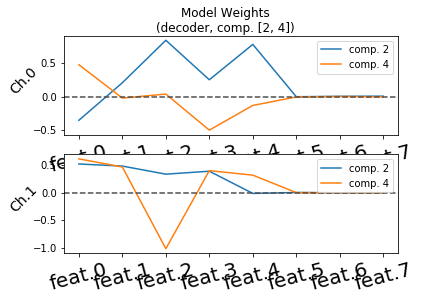

In [115]:
## Plotting the weights of the decoder

plt.figure(figsize=(12, 8))
diagnostics.plot_weights(model_sparse, side = 'decoder')

Dropout threshold: 0.2
Components kept: [2, 4]


<Figure size 864x576 with 0 Axes>

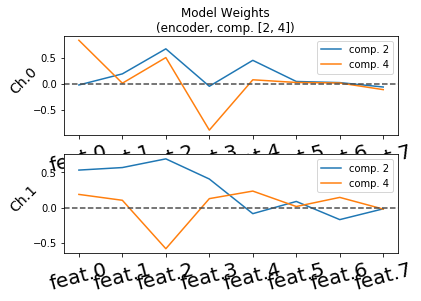

In [116]:
plt.figure(figsize=(12, 8))
diagnostics.plot_weights(model_sparse, side = 'encoder')

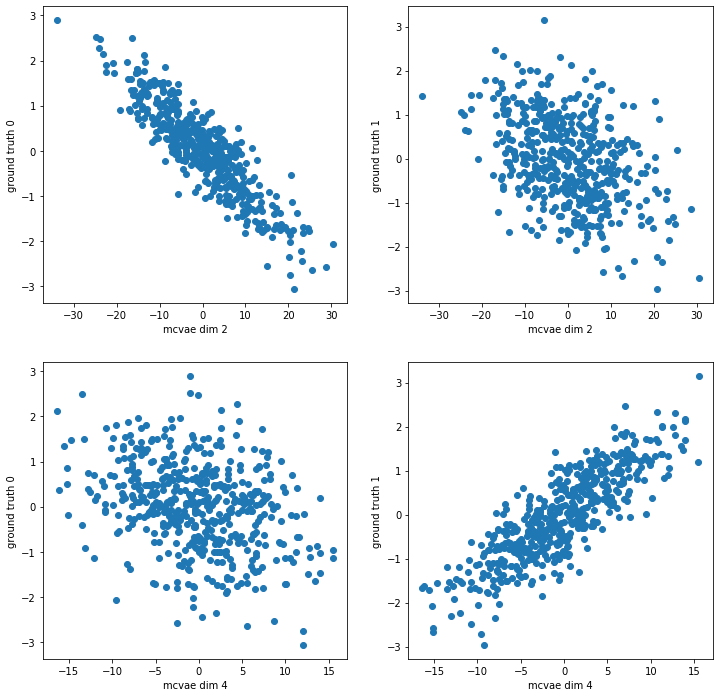

In [117]:
# PLotting estimated encoding vs ground truth

encoding = model_sparse.encode(data_sparse)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()

plt.figure(figsize=(12, 12))
for idx,k in enumerate(indices):
  plt.subplot(len(indices),2,2*idx+1)
  plt.scatter(encoding_x[:,k], latents[:,0])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 0')
  plt.subplot(len(indices),2,2*idx+2)
  plt.scatter(encoding_x[:,k], latents[:,1])
  plt.xlabel(str('mcvae dim ') + str(k))
  plt.ylabel('ground truth 1')

plt.show()

Dropout threshold: 0.5
Components kept: [0, 1]


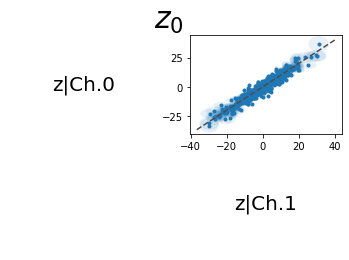

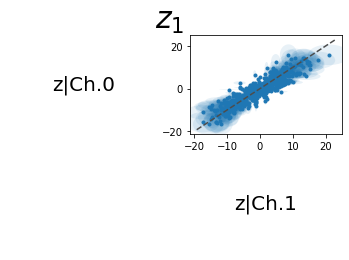

In [118]:
diagnostics.plot_latent_space(model_sparse1, data)

### Increasing the number of channels

In this section we explore the use of the model on data with multiple modalities (or channels)

In [0]:
# generating a new modality z
# This modality has meaningful as well as redundant dimensions

size_z = 3
size_z_redundant = 4

transform_z = np.random.randint(-8,8, size = 2*size_z).reshape([2,size_z])

Z = latents.dot(transform_z) + 2*np.random.normal(size = n*size_z).reshape((n, size_z))
Z = np.hstack([Z,np.random.randn(n*size_z_redundant).reshape([n,size_z_redundant])])

In [123]:
init_dict = {
    'n_channels': 3, # X and Y
    'lat_dim': n_components + 3,
    'n_feats': tuple([X_ext.shape[1], Y_ext.shape[1], Z.shape[1]]),
}


data_multi = []
data_multi.append(torch.FloatTensor(X_ext))
data_multi.append(torch.FloatTensor(Y_ext))
data_multi.append(torch.FloatTensor(Z))

adam_lr = 1e-2
n_epochs = 4000

model_multi = pytorch_modules.MultiChannelSparseVAE(**init_dict)

model_multi.init_loss()
model_multi.optimizer = torch.optim.Adam(model_multi.parameters(), lr=adam_lr)
model_multi.optimize(epochs = n_epochs, data = data_multi)

====> Epoch:    0/4000 (0%)	Loss: 232.2458	LL: -221.9222	KL: 10.3236	LL/KL: -21.4966
====> Epoch:  100/4000 (2%)	Loss: 172.9743	LL: -165.5907	KL: 7.3836	LL/KL: -22.4267
====> Epoch:  200/4000 (5%)	Loss: 160.4065	LL: -152.2349	KL: 8.1717	LL/KL: -18.6296
====> Epoch:  300/4000 (8%)	Loss: 154.4917	LL: -145.0827	KL: 9.4090	LL/KL: -15.4195
====> Epoch:  400/4000 (10%)	Loss: 151.2072	LL: -140.4026	KL: 10.8047	LL/KL: -12.9946
====> Epoch:  500/4000 (12%)	Loss: 149.9696	LL: -137.9112	KL: 12.0584	LL/KL: -11.4370
====> Epoch:  600/4000 (15%)	Loss: 149.0113	LL: -135.9210	KL: 13.0903	LL/KL: -10.3833
====> Epoch:  700/4000 (18%)	Loss: 149.0285	LL: -135.8492	KL: 13.1793	LL/KL: -10.3077
====> Epoch:  800/4000 (20%)	Loss: 149.1895	LL: -136.0865	KL: 13.1029	LL/KL: -10.3860
====> Epoch:  900/4000 (22%)	Loss: 148.7594	LL: -135.6640	KL: 13.0954	LL/KL: -10.3597
====> Epoch: 1000/4000 (25%)	Loss: 148.4888	LL: -135.4798	KL: 13.0090	LL/KL: -10.4143
====> Epoch: 1100/4000 (28%)	Loss: 149.0540	LL: -136.0000	KL:

Probability of redundancy:  [[0.9953263  0.02600033 0.995768   0.9957832  0.9957985  0.99578303
  0.9962048  0.0799811 ]]
Non-redundant components:  [1 7]


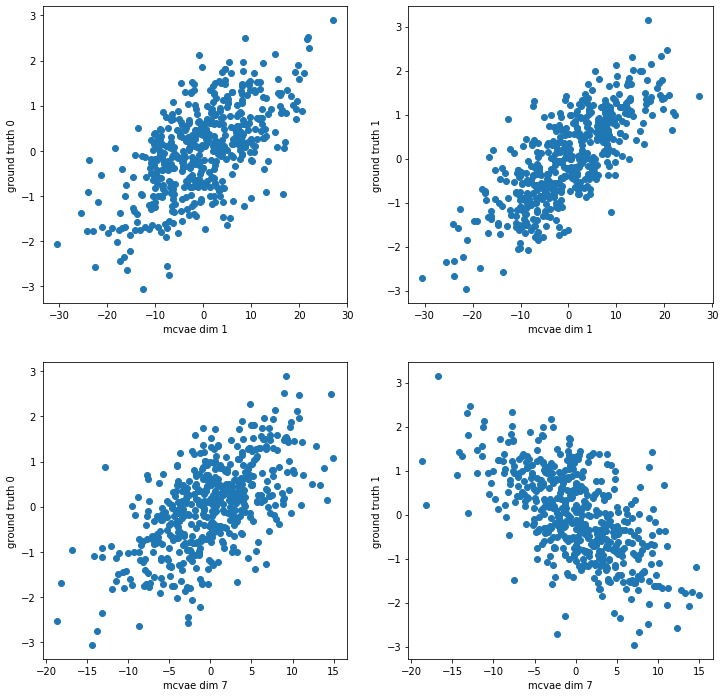

In [124]:
print('Probability of redundancy: ', model_multi.dropout.detach().numpy())
indices = np.where(model_multi.dropout.detach().numpy().flatten() < 0.9)[0]
print('Non-redundant components: ', indices)

model_multi.dropout_threshold = 0.2

encoding = model_multi.encode(data_multi)

encoding_x = encoding[0].loc.detach().numpy()
encoding_y = encoding[1].loc.detach().numpy()
encoding_z = encoding[2].loc.detach().numpy()

plt.figure(figsize=(12, 12))
for idx,k in enumerate(indices):
    plt.subplot(len(indices),2,2*idx+1)
    plt.scatter(encoding_z[:,k], latents[:,0])
    plt.xlabel(str('mcvae dim ') + str(k))
    plt.ylabel('ground truth 0')
    plt.subplot(len(indices),2,2*idx+2)
    plt.scatter(encoding_z[:,k], latents[:,1])
    plt.xlabel(str('mcvae dim ') + str(k))
    plt.ylabel('ground truth 1')

plt.show()

The multi-channel variational autoencoder allows to predict any modality from any other.

In [0]:
# We compute the reconstruction of the data from the encoding
reconstruction = model_multi.decode(model_multi.sample_from(encoding))

# This variable has several dimensions over two indices:
# the first index indicates the modality from which the encoding is done (0:x, 1:y, 3:z, ...) 
# the second index indicates the modality to decode(0:x, 1:y, 3:z, ...)

decoding_x_from_x = reconstruction[0][0].loc.detach().numpy()
decoding_x_from_y = reconstruction[1][0].loc.detach().numpy()
decoding_x_from_z = reconstruction[2][0].loc.detach().numpy()

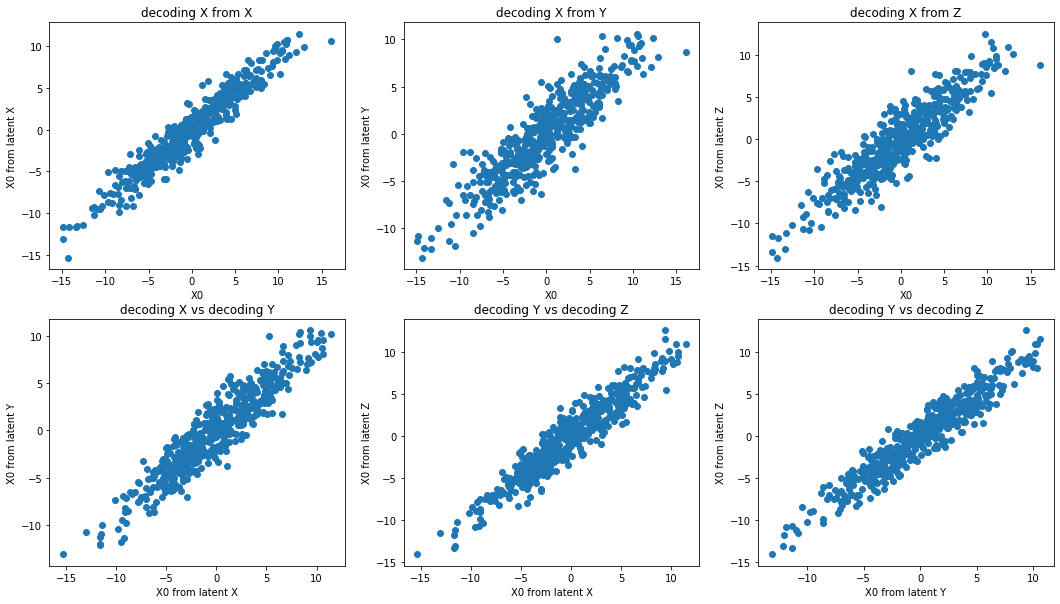

In [127]:
plt.figure(figsize=(18, 10))
plt.subplot(2,3,1)
plt.scatter(X_ext[:,0], decoding_x_from_x[:,0])
plt.title('decoding X from X')
plt.xlabel('X0')
plt.ylabel('X0 from latent X')
plt.subplot(2,3,2)
plt.scatter(X_ext[:,0], decoding_x_from_y[:,0])
plt.title('decoding X from Y')
plt.ylabel('X0 from latent Y')
plt.xlabel('X0')
plt.subplot(2,3,3)
plt.scatter(X_ext[:,0], decoding_x_from_z[:,0])
plt.title('decoding X from Z')
plt.xlabel('X0')
plt.ylabel('X0 from latent Z')
plt.subplot(2,3,4)
plt.scatter(decoding_x_from_x[:,0], decoding_x_from_y[:,0])
plt.title('decoding X vs decoding Y')
plt.xlabel('X0 from latent X')
plt.ylabel('X0 from latent Y')
plt.subplot(2,3,5)
plt.scatter(decoding_x_from_x[:,0], decoding_x_from_z[:,0])
plt.title('decoding Y vs decoding Z')
plt.xlabel('X0 from latent X')
plt.ylabel('X0 from latent Z')
plt.subplot(2,3,6)
plt.scatter(decoding_x_from_y[:,0], decoding_x_from_z[:,0])
plt.title('decoding Y vs decoding Z')
plt.xlabel('X0 from latent Y')
plt.ylabel('X0 from latent Z')
plt.show()

Dropout threshold: 0.2
Components kept: [1, 7]


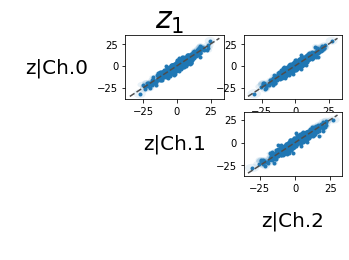

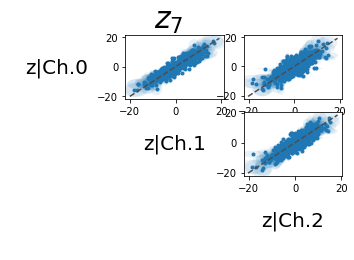

In [128]:
diagnostics.plot_latent_space(model_multi, data_multi)

### Example on ADNI data

In this last application we apply the multichannel autoencoder to the ADNI data, for jointly modeling different modalities across individuals. We wil focus on the joint analysis of:

- brain volumes;
- sociodemographic information (e.g. age, sex, scholarity); 
- cognition; 
- apoe genotype;
- fluid biomarkers (abeta and tay concentrations in the CSF).

In [0]:
import pandas as pd
import torch
from mcvae import pytorch_modules, utilities, preprocessing, plot, diagnostics


We first import and standardize the different data modalities.

In [0]:
volumes = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/volumes.csv')
volumes_value = np.array(volumes.iloc[:,2:]).reshape([len(volumes.RID),5])

for i in range(volumes_value.shape[1]):
    volumes_value[:,i] = (volumes_value[:,i] - np.mean(volumes_value[:,i]))/np.std(volumes_value[:,i])

In [0]:
demog = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/demog.csv')
demog_value = np.array(demog.iloc[:,2:]).reshape([len(demog.RID),3])

for i in range(demog_value.shape[1]):
    demog_value[:,i] = (demog_value[:,i] - np.mean(demog_value[:,i]))/np.std(demog_value[:,i])


In [0]:
cognition = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/cognition.csv')
cognition_value = np.array(cognition.iloc[:,2:]).reshape([len(cognition.RID),7])

for i in range(cognition_value.shape[1]):
    cognition_value[:,i] = (cognition_value[:,i] - np.mean(cognition_value[:,i]))/np.std(cognition_value[:,i])

In [0]:
apoe = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/apoe.csv')
apoe_value = np.array(apoe.iloc[:,2:]).reshape([len(apoe.RID),1])

for i in range(apoe_value.shape[1]):
    apoe_value[:,i] = (apoe_value[:,i] - np.mean(apoe_value[:,i]))/np.std(apoe_value[:,i])

In [0]:
fluid = pd.read_csv('https://marcolorenzi.github.io/material/winter_school/fluid.csv')
fluid_value = np.array(fluid.iloc[:,2:]).reshape(len(apoe.RID),3)

for i in range(fluid_value.shape[1]):
    fluid_value[:,i] = (fluid_value[:,i] - np.mean(fluid_value[:,i]))/np.std(fluid_value[:,i])

We have 5 channels in total as an input for the model

In [0]:
# Defining data characteristics

init_dict = {
    'n_channels': 5, 
    'lat_dim': 5, # We fit 5 latent dimensions
    'n_feats': tuple([volumes_value.shape[1], demog_value.shape[1], cognition_value.shape[1], apoe_value.shape[1], fluid_value.shape[1]]),
}

In [0]:
# Creating a list with multimodal data

data_adni = []
data_adni.append(torch.FloatTensor(volumes_value))
data_adni.append(torch.FloatTensor(np.array(demog_value)))
data_adni.append(torch.FloatTensor(cognition_value))
data_adni.append(torch.FloatTensor(apoe_value))
data_adni.append(torch.FloatTensor(fluid_value))

In [137]:
# Running the model

adam_lr = 1e-2
n_epochs = 6000

model_adni = pytorch_modules.MultiChannelSparseVAE(**init_dict)

model_adni.init_loss()
model_adni.optimizer = torch.optim.Adam(model_adni.parameters(), lr=adam_lr)
model_adni.optimize(epochs = n_epochs, data = data_adni)

====> Epoch:    0/6000 (0%)	Loss: 243.2113	LL: -232.4349	KL: 10.7765	LL/KL: -21.5688
====> Epoch:  100/6000 (2%)	Loss: 193.2305	LL: -188.2483	KL: 4.9822	LL/KL: -37.7843
====> Epoch:  200/6000 (3%)	Loss: 156.1643	LL: -153.2857	KL: 2.8787	LL/KL: -53.2490
====> Epoch:  300/6000 (5%)	Loss: 136.6568	LL: -134.5768	KL: 2.0800	LL/KL: -64.7010
====> Epoch:  400/6000 (7%)	Loss: 131.4245	LL: -129.5577	KL: 1.8667	LL/KL: -69.4036
====> Epoch:  500/6000 (8%)	Loss: 130.8185	LL: -128.9248	KL: 1.8937	LL/KL: -68.0813
====> Epoch:  600/6000 (10%)	Loss: 130.8938	LL: -128.9277	KL: 1.9661	LL/KL: -65.5757
====> Epoch:  700/6000 (12%)	Loss: 130.9134	LL: -128.8846	KL: 2.0288	LL/KL: -63.5287
====> Epoch:  800/6000 (13%)	Loss: 130.9895	LL: -128.9262	KL: 2.0632	LL/KL: -62.4872
====> Epoch:  900/6000 (15%)	Loss: 131.0689	LL: -128.9826	KL: 2.0863	LL/KL: -61.8241
====> Epoch: 1000/6000 (17%)	Loss: 131.1614	LL: -129.0660	KL: 2.0954	LL/KL: -61.5956
====> Epoch: 1100/6000 (18%)	Loss: 131.0201	LL: -128.9248	KL: 2.0953	L

The model identified only a significant dimension, that we are going to store and analyze:

In [138]:
print('Significant dimensions: ', model_adni.dropout.detach().numpy())
significant_dim = np.where(model_adni.dropout.detach().numpy()<0.5)[1]


Significant dimensions:  [[0.9975543  0.4524557  0.99745613 0.99763536 0.9974531 ]]


In [139]:
# Here we store in a list the deconding weights estimated for each modality. 
# We are interested in the decoding weights corresponding to the non-redundant dimension

decoding_weights = []

for i in range(init_dict['n_channels']):
    decoding_weights.append(model_adni.W_out[i].weight.detach().numpy()[:,significant_dim[0]])

decoding_weights[0]

array([ 0.25105935, -0.18871282,  0.30579606,  0.2663263 ,  0.28677785],
      dtype=float32)

The weights give us a nice way to interpret how the different modalities interact together.

<BarContainer object of 3 artists>

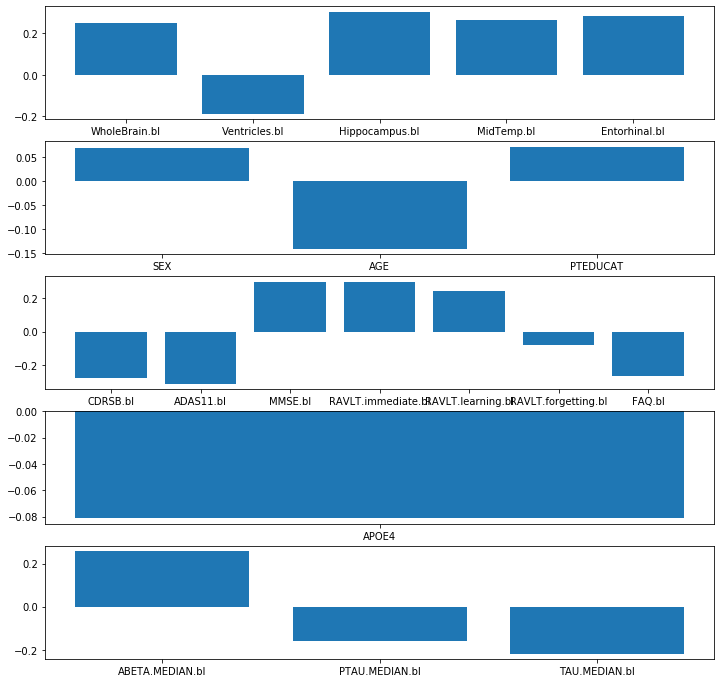

In [140]:
plt.figure(figsize=(12, 12))
plt.subplot(5,1,1)
plt.bar(np.arange(len(decoding_weights[0])), decoding_weights[0], tick_label = volumes.columns[2:])
plt.subplot(5,1,2)
plt.bar(np.arange(len(decoding_weights[1])), decoding_weights[1], tick_label = demog.columns[2:])
plt.subplot(5,1,3)
plt.bar(np.arange(len(decoding_weights[2])), decoding_weights[2], tick_label = cognition.columns[2:])
plt.subplot(5,1,4)
plt.bar(np.arange(len(decoding_weights[3])), decoding_weights[3], tick_label = apoe.columns[2:])
plt.subplot(5,1,5)
plt.bar(np.arange(len(decoding_weights[4])), decoding_weights[4], tick_label = fluid.columns[2:])


Once the model is learnt we can use it for prediction. For example we can predict brain volumes from the cognitive data:

In [0]:
# Storing the predictions
predictions = model_adni.decode(model_adni.sample_from(model_adni.encode(data_adni)))

# Predicting volumes (channel 0) from cognition (channel 2)
decoding_volume_from_cognition = predictions[2][0].loc.detach().numpy()

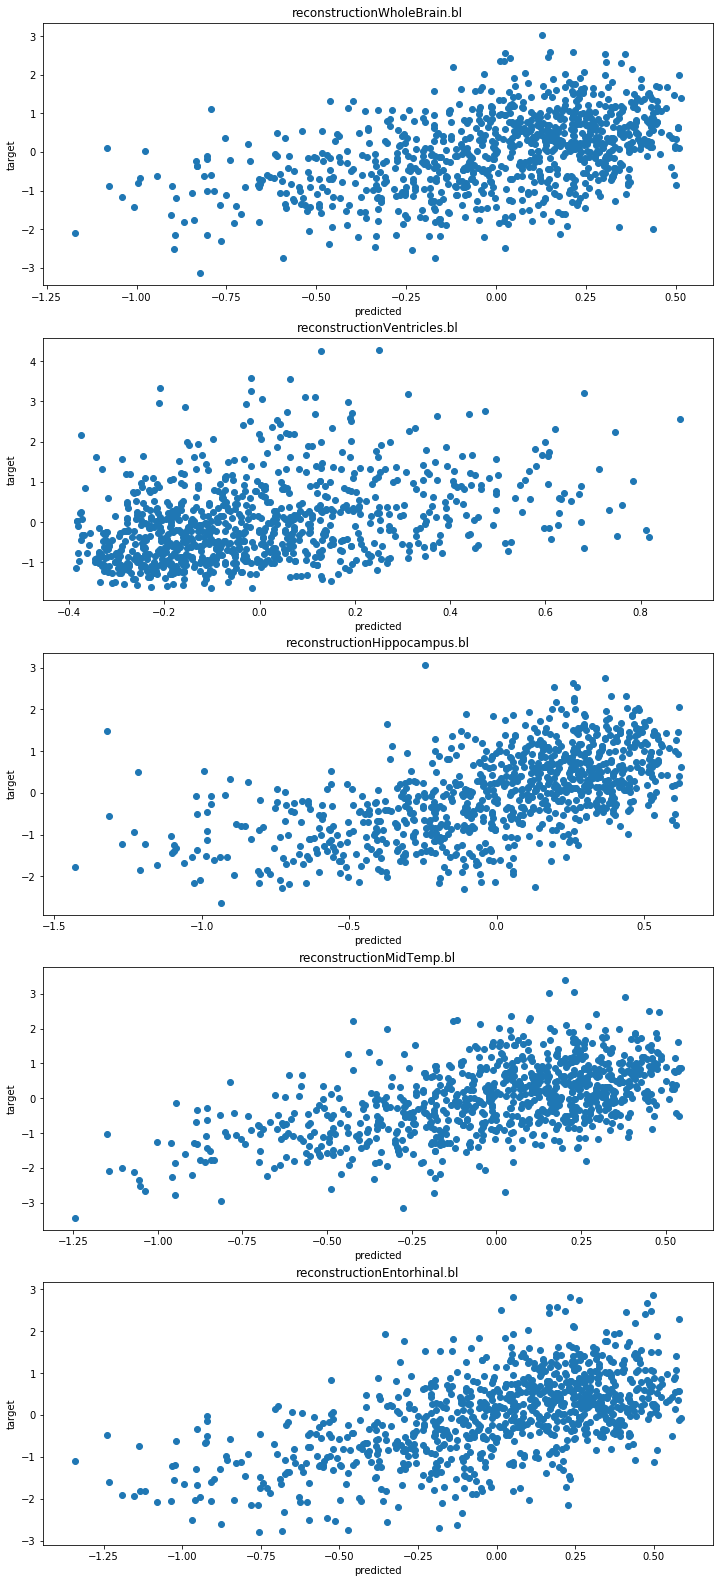

In [143]:
plt.figure(figsize=(12, 28))

# Plotting predictions for each volumetric featurez
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.scatter(decoding_volume_from_cognition[:,i], volumes_value[:,i])
    plt.title('reconstruction ' + volumes.columns[2+i])
    plt.xlabel('predicted')
    plt.ylabel('target')
plt.show()

We are finally going to compare the multichannel model with the standard PLS modeling cognition and brain volumes jointly:

In [144]:
plsca = PLSCanonical(n_components=3, scale = False)
plsca.fit(cognition_value,volumes_value)
print(plsca.x_weights_)
print(plsca.y_weights_)

[[ 0.39899923  0.10784175  0.46702126]
 [ 0.46449063 -0.17600757  0.30801738]
 [-0.41970768  0.02252307  0.05284719]
 [-0.41480449  0.25193258  0.5752117 ]
 [-0.33759258 -0.35942915  0.527915  ]
 [ 0.09007329  0.86611085  0.09016765]
 [ 0.39338126 -0.11864597  0.25793539]]
[[-0.39539685  0.40966994  0.55358155]
 [ 0.30948675 -0.25355692  0.03687062]
 [-0.50592711 -0.48090226  0.50498596]
 [-0.48167611  0.53524535 -0.4254469 ]
 [-0.50980895 -0.50012484 -0.50613451]]


We obtain predictions from the PLS model and compare them with the predictions of mcvae. We observe a strong correlation between predictions. However, as we increase the number of dimensions of CCA, the difference between prediction increases, as CCA tends to overfit. 

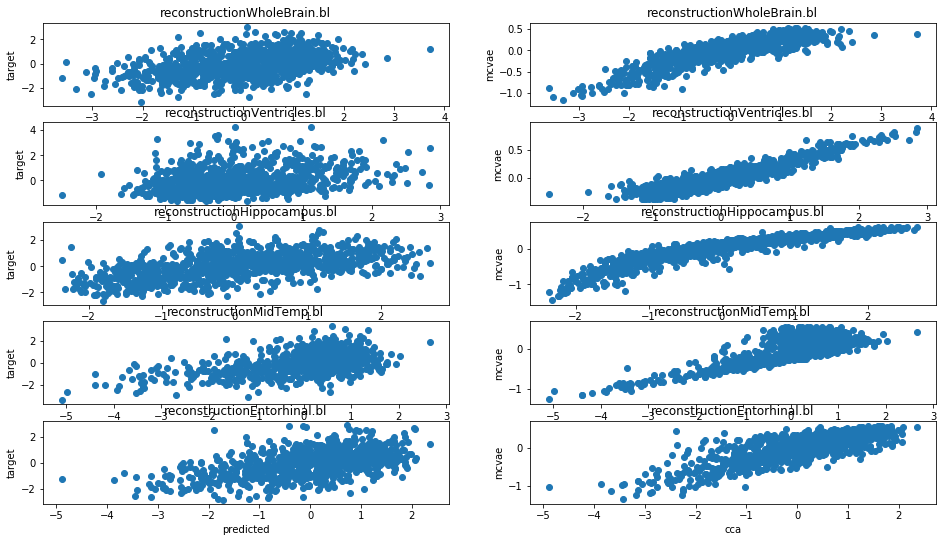

In [145]:
predicted_plsca = plsca.predict(cognition_value)

plt.figure(figsize=(16, 18))

for i in range(5):
    plt.subplot(10,2,2*i+1)
    plt.scatter(predicted_plsca[:,i], volumes_value[:,i])
    plt.title('reconstruction' + volumes.columns[2+i])
    plt.xlabel('predicted')
    plt.ylabel('target')
       
for i in range(5):
    plt.subplot(10,2,2*i+2)
    plt.scatter(predicted_plsca[:,i], decoding_volume_from_cognition[:,i])
    plt.title('reconstruction' + volumes.columns[2+i])
    plt.xlabel('cca')
    plt.ylabel('mcvae')
    
plt.show()

In [146]:
# Comparing average reconstruction errors between models

print('Reconstruction error:')
print('CCA: ' + str(np.sum((predicted_plsca-volumes_value)**2)))
print('mvae: ' + str(np.sum((decoding_volume_from_cognition-volumes_value)**2)))

Reconstruction error:
CCA: 5209.240692014497
mvae: 3524.6333917563456


It is interesting to notice that mcvae leads to a lower reconstruction error than CCA. This may be due to the fact that the prediction of mcvae benefits from training from other modalities as well.